# Customer Segmentation using K-Means and RFM analysis

In [13]:
import pandas as pd
import warnings
import datetime as dt


import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

### Load Data from excel

In [1]:

warnings.filterwarnings('ignore')
# The dataset contains all the transactions occurring between 01/12/2010 and 09/12/2011
# for a UK-based and registered online retailer.
df = pd.read_excel("OnlineRetail.xlsx")
#df[list('CustomerID')] = df[list('CustomerID')].astype(int)

df.head()


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


## Data Discovery and Feature Engineering

In [2]:

customer_country = df[['Country', 'CustomerID']].drop_duplicates()
countries = customer_country.groupby(['Country'])['CustomerID'].aggregate('count')\
    .reset_index().sort_values('CustomerID', ascending=False)

print(countries)

# restrict on UK customers only
df1 = df.loc[df['Country'] == 'United Kingdom']
# remove null values
df1 = df1[pd.notnull(df1['CustomerID'])]

# remove values with negative quantity
df1 = df1[(df1['Quantity'] > 0)]
df1.shape
df1.info()

                 Country  CustomerID
36        United Kingdom        3950
14               Germany          95
13                France          87
31                 Spain          31
3                Belgium          25
33           Switzerland          21
27              Portugal          19
19                 Italy          15
12               Finland          12
1                Austria          11
25                Norway          10
24           Netherlands           9
0              Australia           9
6        Channel Islands           9
9                Denmark           9
7                 Cyprus           8
32                Sweden           8
20                 Japan           8
26                Poland           6
34                   USA           4
5                 Canada           4
37           Unspecified           4
18                Israel           4
15                Greece           4
10                  EIRE           3
23                 Malta           2
3

In [3]:

# Check unique value for each column.
def unique_counts(df1):

    for i in df1.columns:
       count = df1[i].nunique()
       print(i, ": ", count)

unique_counts(df1)

# Add a column for total price
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']

df1.head()

InvoiceNo :  16649
StockCode :  3645
Description :  3844
Quantity :  294
InvoiceDate :  15615
UnitPrice :  403
CustomerID :  3921
Country :  1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Find out the first and lastorder dates in the data
df1['InvoiceDate'].min()
Timestamp(‘2010–12–01 08:26:00’)
df1['InvoiceDate'].max()
Timestamp(‘2011–12–09 12:49:00’)

### Defining RECENCY FREQUENCY and MONETARY VALUES
Since recency is calculated for a point in time, and the last invoice date is 2011–12–09, 
we will use 2011–12–10 as last date to calculate recency.

In [4]:
# recency is based on most recent date present in the dataset
NOW = dt.datetime(2011, 12, 10)
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])


For featuring RFM dimensions we do use *LAMBDA* functions. The dataset is aggregated by CustomerID and for each Customer we have:
- recency is the distance from most recent date in the dataset
- frequency is the count of operations done
- monetary value is the sum of TotalPrice 

In [19]:

rfmTable = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days,
                                          'InvoiceNo': lambda x: len(x),
                                          'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)

# print("\n\n RFM TABLE IS: \n", rfmTable.head())

# Let’s check the details of the first customer
sample_customer = df1[df1['CustomerID'] == 12346]

sample_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


### Categorize the metrics
In order to shape the dataset in a minimal set of categorical features, we split metrics into segments by using quartiles.
Using quartiles we set 4 segments for each feature, which is  more easy to understand and explain. 
This approach gives us a starting point for the detailed analysis.


In [20]:

quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

# create a segmented RFM table

segmented_rfm = rfmTable

For categorizing the metrics we adopt a different strategy for Recency (on on side) and FM Scores on the other side.
Indeed, best customers are envisaged by **low recency** and **high frequency and monetary values**, namely
- low recency is better than high ones
- high frequency and values is better than low ones


In [23]:

quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

# create a segmented RFM table

segmented_rfm = rfmTable

# The lowest recency, highest frequency and monetary amounts are our best customers.


def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1


# Add segment numbers to  the  newly created segmented RFM table

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency', quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency', quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))


segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)



We now can have the view of our featured dataframe

In [24]:
segmented_rfm.head()


,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


## RFM Clustering using K-Means
We shape a dataframe for clustering on featured RFM Dimensions

In [25]:

cluster_df = segmented_rfm[['r_quartile', 'f_quartile', 'm_quartile']]


#### K-Means Clustering
We approach customer segmentation using KMeans. For defining the number of cluster (K) we analyse the *Sum of distances of samples to their closest cluster center* (inertia) for a series of attempts having different K values

n_clusters: 3  cost: 5.259100012461669e-07
n_clusters: 4  cost: 3.985394631937887e-07
n_clusters: 5  cost: 3.455050864405667e-07
n_clusters: 6  cost: 2.909136590666438e-07
n_clusters: 7  cost: 2.703337349495714e-07
n_clusters: 8  cost: 2.4983341497248573e-07
n_clusters: 9  cost: 2.1862423504681256e-07
n_clusters: 10  cost: 2.030285867615299e-07


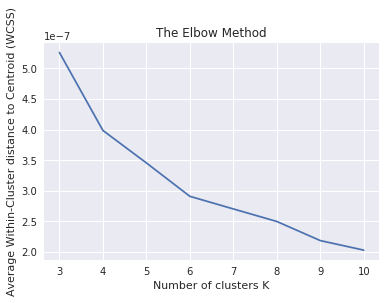

In [26]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# numero di cluster ipotizzabili
scores = pd.DataFrame()
scores['n_clusters'] = [3, 4, 5, 6, 7, 8, 9, 10]

for k in scores['n_clusters']:
    # Create a kmeans model on our data, using k clusters.  
    # random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=10).fit(cluster_df.iloc[:, :])

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    inertia= kmeans_model.inertia_
    print("n_clusters:", k, " cost:", inertia / 10000000000)
    scores.loc[scores['n_clusters'] == k, 'score'] = inertia / 10000000000


plt.plot(scores['n_clusters'], scores['score'])

#plt.plot(scores) # plotting by columns
plt.title('The Elbow Method')
plt.xlabel('Number of clusters K')
plt.ylabel('Average Within-Cluster distance to Centroid (WCSS)')
plt.show()


Given the errors representation, we approach Number of clusters as 6 and thereby we fit the model

In [27]:
#  fix the N CLUSTERS:
N_CL=6

kmeans = KMeans(n_clusters=N_CL, random_state=10)
kmeans.fit(cluster_df)
y_kmeans = kmeans.predict(cluster_df)

In [28]:

cluster_df['kmeans_cluster'] = y_kmeans

print(" \n ******** \n CLUSTER SEGMENTED RFM: \n ********** \n ")
cluster_df.head(10)


 
 ******** 
 CLUSTER SEGMENTED RFM: 
 ********** 
 


,r_quartile,f_quartile,m_quartile,kmeans_cluster
CustomerID,,,,
12346.0,4,4,1,5
12747.0,1,1,1,1
12748.0,1,1,1,1
12749.0,1,1,1,1
12820.0,1,2,2,2
12821.0,4,4,4,0
12822.0,3,2,2,4
12823.0,3,4,1,5
12824.0,3,3,3,5


which gives a grouped amount of customers distributed in each cluster

In [32]:

cluster_df.groupby(['kmeans_cluster']).size()

kmeans_cluster
0    826
1    890
2    547
3    536
4    465
5    657
dtype: int64

Finally, we can assess clusters analyzing their centroids. 


In [30]:
# cluster centers
centers = np.array(kmeans_model.cluster_centers_)
print(" Centers:  ", centers)



 Centers:   [[3.63375224 2.81328546 3.33572711]
 [1.         1.77808989 1.88483146]
 [2.45522388 1.25870647 1.        ]
 [1.67021277 3.47163121 4.        ]
 [3.64409222 4.         3.73631124]
 [1.99688474 1.68224299 2.25856698]
 [3.23423423 3.35585586 1.72972973]
 [1.         1.         1.        ]
 [1.58333333 3.24712644 2.63793103]
 [3.26969697 1.77575758 2.16969697]]


Reminding that in the categories given **Low is better**, the best cluster is the 3 one (536 elements), having center in 1,1,1